# Time Series window data 생성 및 모델별 성능 비교

1. Persistence algorithm 을 이용한 forecasting 
2. simple 1 layer NN 을 이용한 forecasting  
3. Deep NN을  이용한 forecasting  
4. LSTM 을  이용한 forecasting

## Sunspots 데이터셋을 활용하여 window_dataset 만들기

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0) # 첫 줄은 header이므로 skip 
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [5]:
df.tail()

,Date,Monthly Mean Total Sunspot Number
3230,2018-03-31,2.5
3231,2018-04-30,8.9
3232,2018-05-31,13.2
3233,2018-06-30,15.9
3234,2018-07-31,1.6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3235 entries, 0 to 3234
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3235 non-null   object 
 1   Monthly Mean Total Sunspot Number  3235 non-null   float64
dtypes: float64(1), object(1)
memory usage: 75.8+ KB


- 시간 절약을 위해 최근 500 개월치 data 만 이용

In [7]:
time = df.iloc[-500:, 0].values
time_series = df.iloc[-500:, 1].values
time.shape, time_series.shape

((500,), (500,))

## Supervised Learning dataset 작성

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

### train/validation set 분리

In [9]:
split_time = 450

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(450, 50, 450, 50)

In [10]:
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [11]:
for x, y in train_ds:
    print('x = ', x.numpy().shape)
    print('y = ', y.numpy().shape)
    break

x =  (16, 20)
y =  (16,)


## 1. Persistence algorithm 을 이용한 forecasting 

- Persistence Algorithm : last value 를 next value 로 예측에 사용

In [12]:
naive_forecast = time_series[split_time-1:-1]
naive_forecast[:10]

array([112.5, 102.9, 100.2, 106.9, 130. ,  90. , 103.6, 112.9,  93. ,
        66.7])

In [13]:
X_test[:10]

array([102.9, 100.2, 106.9, 130. ,  90. , 103.6, 112.9,  93. ,  66.7,
        54.5])

In [14]:
print(mean_squared_error(X_test, naive_forecast))
print(mean_absolute_error(X_test, naive_forecast))

194.96940000000004
10.737999999999998


## 2. simple 1 layer NN 을 이용한 forecasting - Linear Regression

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=[window_size])
])

model.compile(loss='mse', optimizer='adam')
model.fit(train_ds, epochs=100, verbose=1)

Epoch 1/100
27/27 [==============================] - 1s 21ms/step - loss: 32367.8789
Epoch 2/100
27/27 [==============================] - 0s 575us/step - loss: 17185.1992
Epoch 3/100
27/27 [==============================] - 0s 537us/step - loss: 9562.5117
Epoch 4/100
27/27 [==============================] - 0s 535us/step - loss: 6533.7261
Epoch 5/100
27/27 [==============================] - 0s 536us/step - loss: 5512.8955
Epoch 6/100
27/27 [==============================] - 0s 573us/step - loss: 5127.9595
Epoch 7/100
27/27 [==============================] - 0s 499us/step - loss: 4928.0034
Epoch 8/100
27/27 [==============================] - 0s 575us/step - loss: 4751.2124
Epoch 9/100
27/27 [==============================] - 0s 536us/step - loss: 4558.7446
Epoch 10/100
27/27 [==============================] - 0s 537us/step - loss: 4357.7593
Epoch 11/100
27/27 [==============================] - 0s 499us/step - loss: 4181.7485
Epoch 12/100
27/27 [==============================] - 0s 537us

27/27 [==============================] - 0s 498us/step - loss: 917.3815
Epoch 97/100
27/27 [==============================] - 0s 535us/step - loss: 915.5777
Epoch 98/100
27/27 [==============================] - 0s 461us/step - loss: 919.7249
Epoch 99/100
27/27 [==============================] - 0s 538us/step - loss: 905.4535
Epoch 100/100
27/27 [==============================] - 0s 499us/step - loss: 901.2333


In [16]:
forecast = []

for time in range(len(time_series) - window_size):
    prediction = model.predict(time_series[time:time+window_size].reshape(1, -1))
    forecast.append(prediction[0][0])
    
result = forecast[split_time-window_size:]
result[:10]

[149.0018,
 105.876686,
 103.002914,
 128.72046,
 111.5388,
 99.12656,
 89.4261,
 115.508965,
 77.15461,
 82.20285]

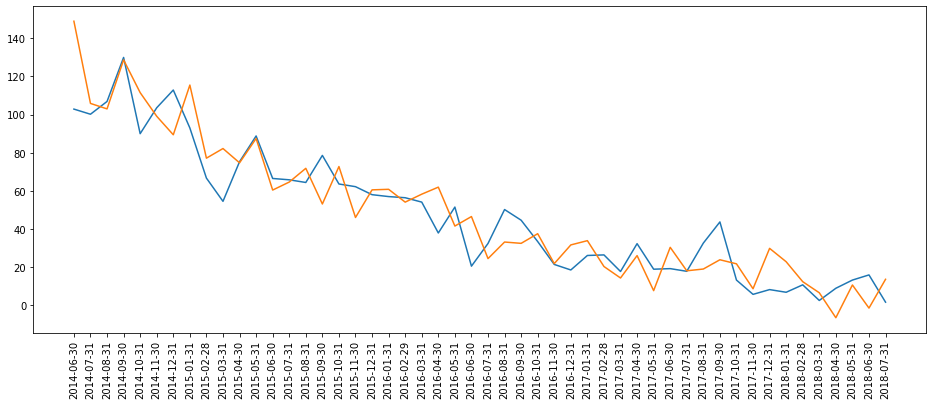

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test)
plt.plot(time_test, result)
plt.xticks(rotation=90)
plt.show()

In [18]:
print(tf.keras.metrics.mean_squared_error(X_test, result).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, result).numpy())

205.3577
10.881822


## 3. Deep NN을  이용한 forecasting

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer='adam')

history = model.fit(train_ds,epochs=100,verbose=1)

Epoch 1/100
27/27 [==============================] - 0s 1ms/step - loss: 3649.1924
Epoch 2/100
27/27 [==============================] - 0s 614us/step - loss: 1328.0858
Epoch 3/100
27/27 [==============================] - 0s 614us/step - loss: 912.2199
Epoch 4/100
27/27 [==============================] - 0s 614us/step - loss: 827.7393
Epoch 5/100
27/27 [==============================] - 0s 614us/step - loss: 824.4335
Epoch 6/100
27/27 [==============================] - 0s 575us/step - loss: 713.2470
Epoch 7/100
27/27 [==============================] - 0s 575us/step - loss: 711.7651
Epoch 8/100
27/27 [==============================] - 0s 652us/step - loss: 701.3011
Epoch 9/100
27/27 [==============================] - 0s 652us/step - loss: 688.0028
Epoch 10/100
27/27 [==============================] - 0s 652us/step - loss: 669.5054
Epoch 11/100
27/27 [==============================] - 0s 652us/step - loss: 688.7356
Epoch 12/100
27/27 [==============================] - 0s 614us/step - loss

27/27 [==============================] - 0s 613us/step - loss: 421.8001
Epoch 98/100
27/27 [==============================] - 0s 613us/step - loss: 455.6635
Epoch 99/100
27/27 [==============================] - 0s 614us/step - loss: 446.8969
Epoch 100/100
27/27 [==============================] - 0s 614us/step - loss: 414.4923


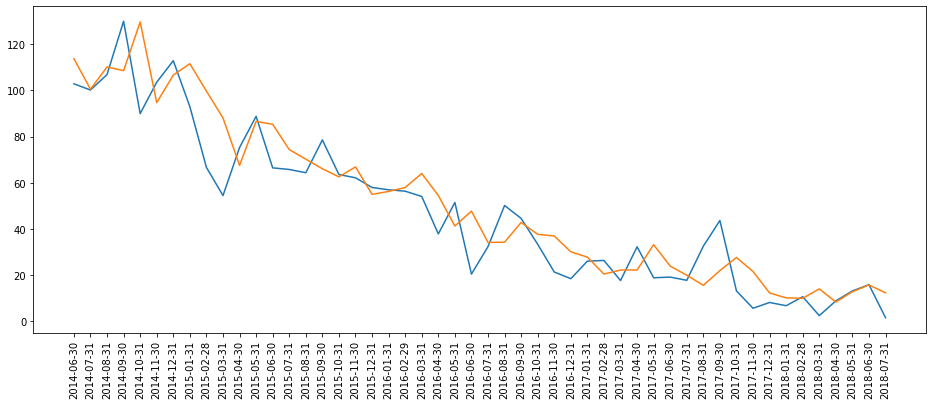

In [20]:
forecast = []

for time in range(len(time_series) - window_size):
    prediction = model.predict(time_series[time:time+window_size].reshape(1, -1))
    forecast.append(prediction[0][0])
    
result = forecast[split_time-window_size:]

plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test)
plt.plot(time_test, result)
plt.xticks(rotation=90)
plt.show()

In [21]:
print(tf.keras.metrics.mean_squared_error(X_test, result).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, result).numpy())

186.69997
10.032865


## 4. LSTM 을  이용한 forecasting

- RNN 은 3 Dimension input 이 필요하므로 Lambda layer 를 이용하여 2D $\rightarrow$ 3D expand  

### 4-1. Simple LSTM

- 첫 번째 람다 레이어는 차원을 확장하는 데 도움이 됩니다. 여기서는 배열을 1차원 확장하고 모델이 모든 길이의 시퀀스를 사용할 수 있음을 의미하는 input_shape=[None]을 설정 합니다.

- 최종 람다 계층은 출력을 100배 확장하여 훈련에 도움이 될 수 있습니다. RNN의 기본 레이어는 -1과 1 사이의 값을 출력하는 tanh입니다. 출력을 스케일링하면 이러한 값을 일반적으로 40, 50, 60 등의 값인 시계열에 더 가깝게 만들 수 있습니다.

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.LSTM(32, input_shape=[window_size, 1]),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_ds, epochs=100, verbose=1)

Epoch 1/100
27/27 [==============================] - 1s 3ms/step - loss: 45756.2734
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 23739.4531
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 11882.7998
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 6821.6421
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 2495.3840
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 1850.7050
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 1603.9283
Epoch 8/100
27/27 [==============================] - 0s 3ms/step - loss: 1388.9843
Epoch 9/100
27/27 [==============================] - 0s 3ms/step - loss: 1233.9769
Epoch 10/100
27/27 [==============================] - 0s 3ms/step - loss: 1175.4673
Epoch 11/100
27/27 [==============================] - 0s 3ms/step - loss: 1016.9322
Epoch 12/100
27/27 [==============================] - 0s 3ms/step - loss: 914.0861

27/27 [==============================] - 0s 3ms/step - loss: 633.2274
Epoch 100/100
27/27 [==============================] - 0s 3ms/step - loss: 617.4275


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


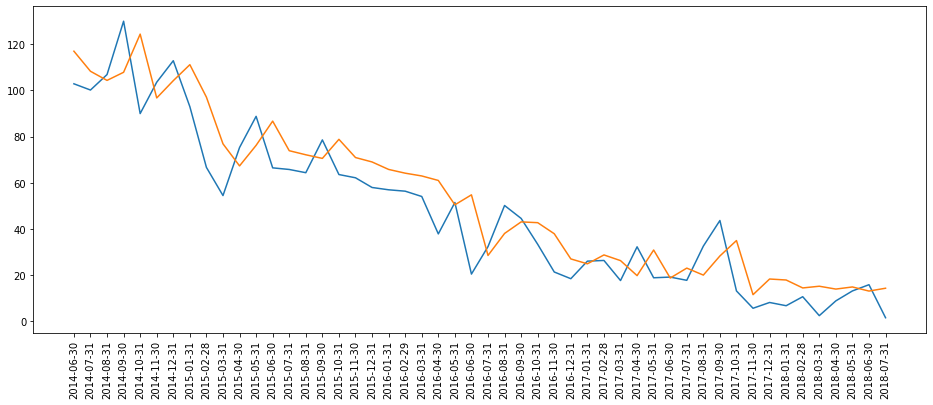

In [24]:
forecast = []

for time in range(len(time_series) - window_size):
    prediction = model.predict(time_series[time:time+window_size].reshape(1, -1))
    forecast.append(prediction[0][0])
    
result = forecast[split_time-window_size:]

plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test)
plt.plot(time_test, result)
plt.xticks(rotation=90)
plt.show()

In [25]:
print(tf.keras.metrics.mean_squared_error(X_test, result).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, result).numpy())

190.50763
11.231525


### 4-2. Stacked + Bidirectoinal LSTM

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_ds, epochs=100, verbose=1)

Epoch 1/100
27/27 [==============================] - 3s 7ms/step - loss: 4262.6777
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 1222.4335
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 852.8459
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 753.8591
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 749.8372
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 701.9381
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 686.4423
Epoch 8/100
27/27 [==============================] - 0s 6ms/step - loss: 737.8510
Epoch 9/100
27/27 [==============================] - 0s 6ms/step - loss: 758.6470
Epoch 10/100
27/27 [==============================] - 0s 6ms/step - loss: 703.5085
Epoch 11/100
27/27 [==============================] - 0s 6ms/step - loss: 676.0713
Epoch 12/100
27/27 [==============================] - 0s 6ms/step - loss: 670.1626
Epoch 13/10

27/27 [==============================] - 0s 6ms/step - loss: 615.5073
Epoch 100/100
27/27 [==============================] - 0s 6ms/step - loss: 550.6968


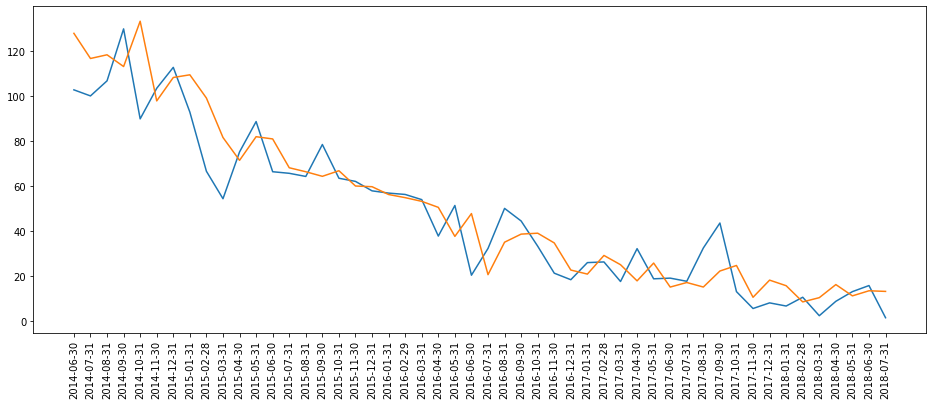

In [27]:
forecast = []

for time in range(len(time_series) - window_size):
    prediction = model.predict(time_series[time:time+window_size].reshape(1, -1))
    forecast.append(prediction[0][0])
    
result = forecast[split_time-window_size:]

plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test)
plt.plot(time_test, result)
plt.xticks(rotation=90)
plt.show()

In [28]:
print(tf.keras.metrics.mean_squared_error(X_test, result).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, result).numpy())

185.96494
10.257263
